# CDC

## Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl
from sklearn.linear_model import LinearRegression

os.chdir("../../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.experience import charters
from morai.integrations import cdc
from morai.utils import helpers, sql

In [3]:
pd.options.display.float_format = "{:,.2f}".format

reference: https://github.com/alipphardt/cdc-wonder-api

In [4]:
db_filepath = r"files/integrations/cdc/cdc.sql"

In [543]:
import importlib

importlib.reload(cdc)
importlib.reload(sql)

<module 'morai.utils.sql' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\utils\\sql.py'>

In [5]:
sql.get_tables(db_filepath=db_filepath)

['cod_prov', 'cod_hist', 'cod_monthly', 'mi']

## COD

### CDC Query
Querying the historical and provisional data

In [420]:
df = cdc.get_cdc_data_xml(xml_filename="cod_hist.xml")

In [421]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="cod_hist",
    if_exists="replace",
)

 2024-07-21 18:58:44 | morai.utils.sql | INFO     | exporting data to SQLite database: files/integrations/cdc/cdc.sql and table: cod_hist 


In [413]:
df = cdc.get_cdc_data_xml(xml_filename="cod_prov.xml")

In [415]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="cod_prov",
    if_exists="replace",
)

 2024-07-21 11:41:00 | morai.utils.sql | INFO     | exporting data to SQLite database: files/integrations/cdc/cdc.sql and table: cod_prov 


### SQL
Load from SQL database

In [422]:
cod_hist = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="cod_hist")

 2024-07-21 18:58:47 | morai.integrations.cdc | INFO     | table `cod_hist` last updated at: 2024-07-21 18:58:44 


In [418]:
cod_prov = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="cod_prov")

 2024-07-21 18:56:37 | morai.integrations.cdc | INFO     | table `cod_prov` last updated at: 2024-07-21 11:41:00 


### Aggregate
Aggregating the historical and provisional and mapping columns to more friendly names

In [426]:
# variable initiation
category_col = "chapter_simple"

In [427]:
cod_prov = cod_prov[cod_prov["year"] >= 2021]
cod_all = pd.concat([cod_hist, cod_prov], ignore_index=True)

In [430]:
cod_all = cdc.map_reference(
    df=cod_all, col=category_col, index_dict={"icd_-_chapter": "chapter_wonder"}
)
cod_all = cod_all[(cod_all["year"] != 2024)]

 2024-07-21 19:58:55 | morai.integrations.cdc | INFO     | mapping column: chapter_simple 


In [431]:
totals = cod_all.groupby("year").sum(numeric_only=True).reset_index()
totals[category_col] = "total"
cod_all = pd.concat([cod_all, totals], ignore_index=True)

In [440]:
category_orders = charters.get_category_orders(
    df=cod_all, category=category_col, measure="deaths"
)

### Predict

In [436]:
# train the data based on year and the category using linear regression
train_df = cod_all[(cod_all["year"] >= 2015) & (cod_all["year"] <= 2019)]
train_df = train_df.groupby(["year", category_col])["deaths"].sum().reset_index()

In [478]:
# create the models
models = {}
for cod in train_df[category_col].unique():
    cod_subset = train_df[train_df[category_col] == cod]
    X = (cod_subset["year"] - 2015).values.reshape(-1, 1)
    y = cod_subset["deaths"].values
    model = LinearRegression().fit(X, y)
    models[cod] = {
        "model": model,
        "coef": model.coef_[0],
        "intercept": model.intercept_,
    }

In [480]:
# make the predictions
test_df = cod_all[(cod_all["year"] >= 2020)]
test_df = test_df.groupby(["year", category_col])["deaths"].sum().reset_index()

for cod, model in models.items():
    mask = test_df[category_col] == cod
    if mask.sum() > 0:
        X = (test_df.loc[mask, "year"] - 2015).values.reshape(-1, 1)
        test_df.loc[mask, "pred"] = model["model"].predict(X)

test_df["diff_abs"] = test_df["deaths"] - test_df["pred"]
test_df["diff_pct"] = (test_df["deaths"] - test_df["pred"]) / test_df["pred"]

In [481]:
summary = charters.chart(
    df=test_df,
    x_axis="year",
    y_axis="diff_abs",
    color=category_col,
    type="area",
    category_orders=category_orders,
    display=False,
)
pivot = summary.pivot(index="chapter_simple", columns="year", values="diff_abs")
pivot.index = pd.Categorical(
    pivot.index, categories=category_orders["chapter_simple"], ordered=True
)
pivot = pivot.sort_index()
pivot

year,2020,2021,2022,2023
total,"477,031.20","519,595.00","297,282.80","70,052.60"
circulatory,"41,580.80","34,006.00","33,668.20","-2,532.60"
neoplasms,"2,248.80","4,414.80","6,664.80","11,012.80"
respiratory,"-8,274.60","-29,565.40","-18,639.20","-22,544.00"
external,"20,727.80","41,228.40","32,671.00","16,838.60"
nervous system,"16,072.90","-5,624.20","-3,623.30","-15,358.40"
other,"15,571.00","4,943.60","8,633.20","2,846.80"
endocrine,"19,413.60","21,670.80","18,472.00","7,865.20"
digestive,"9,645.40","17,524.00","14,363.60","7,977.20"
infectious,"4,529.90","6,460.80","9,520.70","10,491.60"


### Chart

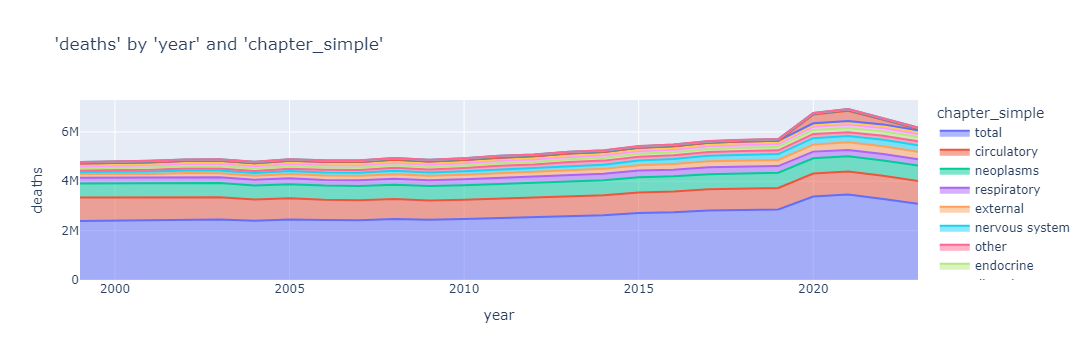

In [444]:
charters.chart(
    df=cod_all,
    x_axis="year",
    y_axis="deaths",
    color=category_col,
    type="area",
    category_orders=category_orders,
)

## Monthly

### CDC Query

In [459]:
cod_monthly = cdc.get_cdc_data_xml(
    xml_filename="cod_monthly.xml", parse_date_col="Month"
)

In [460]:
sql.export_to_sql(df=cod_monthly, db_filepath=db_filepath, table_name="cod_monthly")

 2024-07-21 20:17:28 | morai.utils.sql | INFO     | exporting data to SQLite database: files/integrations/cdc/cdc.sql and table: cod_monthly 


### SQL

In [462]:
cod_monthly = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="cod_monthly")

 2024-07-21 20:18:02 | morai.integrations.cdc | INFO     | table `cod_monthly` last updated at: 2024-07-21 20:17:28 


### Chart

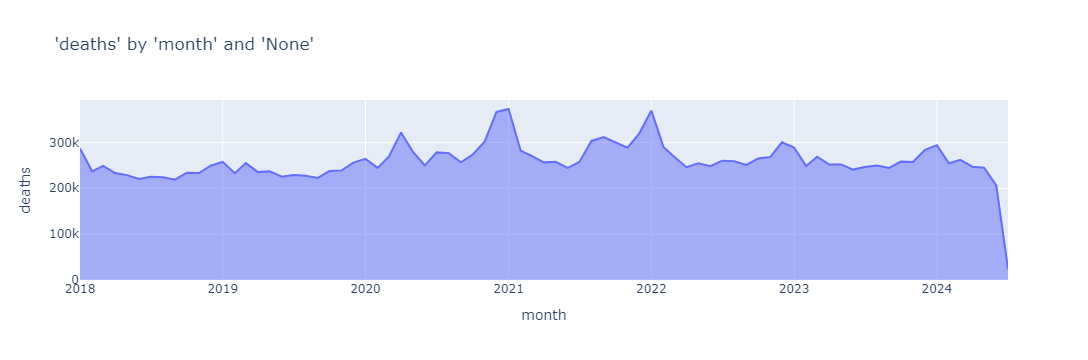

In [464]:
charters.chart(
    df=cod_monthly,
    x_axis="month",
    y_axis="deaths",
    type="area",
)

## MI

### CDC Query

In [514]:
df = cdc.get_cdc_data_xml(xml_filename="mi.xml")
df['quintile'] = "total"

In [515]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mi",
    if_exists="replace",
)

 2024-07-22 00:03:04 | morai.utils.sql | INFO     | exporting data to SQLite database: files/integrations/cdc/cdc.sql and table: mi 


In [7]:
df = cdc.get_cdc_data_xml(xml_filename="mi_quintile_1.xml")

In [9]:
df['quintile'] = "1"

,age_groups,gender,year,deaths,population,crude_rate,quintile
0,< 1 year,Female,1999,12291,"1,852,123.00",663.6,1
1,< 1 year,Female,2000,12317,"1,856,631.00",663.4,1
2,< 1 year,Female,2001,12091,"1,962,905.00",616.0,1
3,< 1 year,Female,2002,12317,"1,932,939.00",637.2,1
4,< 1 year,Female,2003,12123,"1,942,634.00",624.0,1
...,...,...,...,...,...,...,...
523,Not Stated,Male,2016,97,NaN,Not Applicable,1
524,Not Stated,Male,2017,91,NaN,Not Applicable,1
525,Not Stated,Male,2018,109,NaN,Not Applicable,1
526,Not Stated,Male,2019,103,NaN,Not Applicable,1


### SQL

In [637]:
mi = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mi")

 2024-07-22 16:51:33 | morai.integrations.cdc | INFO     | table `mi` last updated at: 2024-07-22 00:03:04 


### Aggregate

### Calculate

In [632]:
# filters
mi = mi[mi["year"] < 2020]

In [633]:
# group and calculate 2000 adjusted crude
mi = mi.groupby(["year", "age_groups"])[["deaths", "population"]].sum().reset_index()

mi = cdc.map_reference(
    df=mi,
    col='value',
    index_dict={"age_groups": "key"},
    sheet_name="mapping",
)

mi = cdc.map_reference(
    df=mi,
    col='%',
    index_dict={"value": "age"},
    sheet_name="age_std_2000",
)

In [635]:
# calculate crude and mi
mi["crude_adj"] = mi["deaths"] / mi["population"] * 100000 * mi["%"]
mi = mi.groupby(["year"])[["crude_adj"]].sum().reset_index()
mi["1_year_mi"] = 1 - (mi["crude_adj"] / mi["crude_adj"].shift(1))
mi["10_year_mi"] = mi['1_year_mi'].rolling(window=10).mean()

### Chart

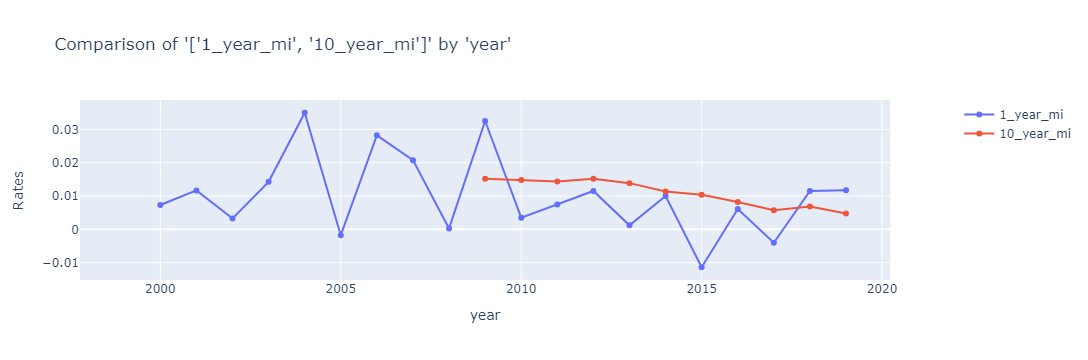

In [636]:
charters.compare_rates(
    df=mi,
    x_axis="year",
    rates=["1_year_mi", "10_year_mi"],
)

## Other Functions

In [414]:
sql.table_remove(db_filepath=db_filepath, table_name="cdc_prov")

 2024-07-21 11:40:54 | morai.utils.sql | INFO     | table `cdc_prov` removed from `files/integrations/cdc/cdc.sql` 


In [466]:
sql.table_dtypes(db_filepath=db_filepath, table_name="cod_monthly")

{'year': 'INTEGER',
 'month': 'TIMESTAMP',
 'deaths': 'INTEGER',
 'population': 'TEXT',
 'crude_rate': 'TEXT',
 'added_at': 'TEXT'}